In [101]:
from scipy.ndimage.filters import convolve as filter2
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import io
import os
%matplotlib inline

In [81]:
def extractImages(pathIn, pathOut):
  img_width = 1280
  img_height = 720

  count = 0
  vidcap = cv2.VideoCapture(pathIn)
  success,image = vidcap.read()
  success = True
  while success:
    vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*100))    # added this line 
    success,image = vidcap.read()
    print ('Read a new frame: ', success)
    # print(image)
    if(success):
      # cv2.imwrite( pathOut + "/frame_%d.jpg" % count, image)     # save frame as JPEG file
      img_encoded = cv2.imencode('.jpg', image)[1]
      img_bytes = img_encoded.tobytes()
      img = Image.open(io.BytesIO(img_bytes))
      img = img.resize((img_width, img_height), Image.ANTIALIAS)
      img.save(pathOut+"/image_%d.jpg"%(count + 1))
      if(count >= 1):
        break
      count = count + 1


In [ ]:
pathIn = "{0}/video.mp4".format(os.getcwd())
pathOut = "{0}".format(os.getcwd())
print(pathIn, pathOut)
extractImages(pathIn, pathOut)

In [4]:
def rgb2gray(rgb):
  return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

[Kernel idea](https://drive.google.com/file/d/1OS8qTpdTLHEqzn4eRf5rrDhqYd6AyJUX/view?usp=sharing)

In [6]:

KERNEL_WEIGHT_AVG = np.array([[1/12, 1/6, 1/12],
                   [1/6, 0, 1/6],
                   [1/12, 1/6, 1/12]], float)

KERNEL_X = np.array([[-1, 1],
                    [-1, 1]]) * 0.25 # kernel for computing d/dx

KERNEL_Y = np.array([[-1, -1],
                    [1, 1]]) * 0.25 # kernel for computing d/dy

KERNEL_T = np.array([[1, 1],
                     [1, 1]])

In [7]:
def computeDerivatives(im1, im2):
  fx = filter2(im1, KERNEL_X) + filter2(im2, KERNEL_X)
  fy = filter2(im1, KERNEL_Y) + filter2(im2, KERNEL_Y)

  # ft = im2 - im1
  ft = filter2(im1, KERNEL_T) + filter2(im2, -KERNEL_T)

  return fx, fy, ft

In [10]:
def hornSchunck(im1, im2, *, alpha= 0.001, iter=8):

  im1 = im1.astype(np.float32)
  im2 = im2.astype(np.float32)
  # im1 = im1/255.0
  # im2 = im2/255.0

  # set up initial velocities for flow vectors
  u = np.zeros([im1.shape[0], im1.shape[1]])
  v = np.zeros([im1.shape[0], im1.shape[1]])

  # Estimate derivatives
  [fx, fy, ft] = computeDerivatives(im1, im2)
  
  for i in range(iter):
    # print(i)
    uAvg = filter2(u, KERNEL_WEIGHT_AVG)
    vAvg = filter2(v, KERNEL_WEIGHT_AVG)
    P = (fx*uAvg + fy*vAvg + ft)
    D = (alpha**2 + fx**2 + fy**2)
    P_D = P / D
    u = uAvg - fx * P_D
    v = vAvg - fy * P_D

  return u, v

In [52]:
def draw(image, u, v):
  color = (0, 0, 255)
  thickness = 1
  for i in range(0, len(u), 5):
    for j in range(0, len(u[0]), 5):
      if(u[i][j] != 0 and v[i][j] != 0):
        new_i = int(i + u[i][j])
        new_j = int(j + v[i][j])
        if(abs(new_j - j) >= 5 or abs(new_i - i) >= 5):
          image = cv2.arrowedLine(image, (j, i), (new_j, new_i), color, thickness)
  return image

In [85]:
img1 = plt.imread("image_1.jpg")
img2 = plt.imread("image_2.jpg")

im1 = rgb2gray(img1)
im2 = rgb2gray(img2)
im1 = np.array(im1)
im2 = np.array(im2)


In [86]:
uv = hornSchunck(im1, im2, alpha=10.0, iter=100)

In [87]:
u = uv[0]
v = uv[1]

In [88]:
image1 = cv2.imread("image_1.jpg")

In [90]:
image1 = draw(image1, u, v)

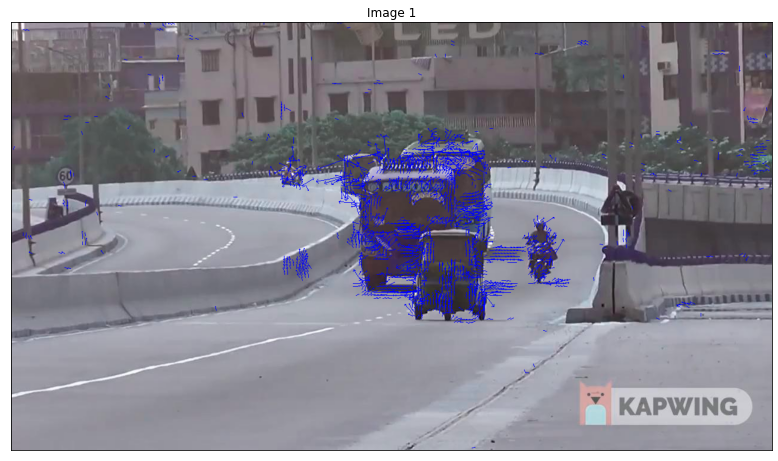

In [91]:
plt.figure(figsize=(30, 25))

plt.subplot(121)
plt.imshow(image1, cmap='gray')
plt.title("Image 1")
plt.xticks([])
plt.yticks([])
plt.show()

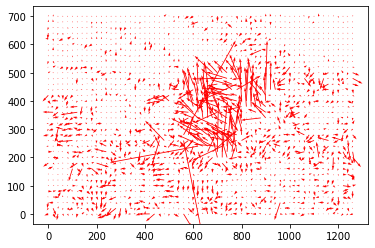

In [93]:
image2 = cv2.imread("image_1.jpg")
r, c,_ = np.shape(image2)

gd = 20
Y, X = np.mgrid[0:r:gd, 0:c:gd]
U=u[0:r:gd, 0:c:gd]
V=v[0:r:gd, 0:c:gd]

fig,ax=plt.subplots(1,1)
ax.quiver(X, Y, U, V, color='r')
plt.show()


In [83]:
def optical_flow_video(pathIn, pathOut):
  img_width = 1280
  img_height = 720
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  output = cv2.VideoWriter(pathOut, fourcc, 15,(img_width, img_height))
  count = 0
  vidcap = cv2.VideoCapture(pathIn)
  success,image = vidcap.read()
  prev_image = image

  while success:
    prev_frame = np.array(rgb2gray(prev_image))
    # vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*50))    # added this line 
    success,image = vidcap.read()
    print ('Read a new frame: ', success, count)
    if(success):
      curr_frame = np.array(rgb2gray(image))
      uv = hornSchunck(prev_frame, curr_frame, alpha=10, iter=100)
      u = uv[0]
      v = uv[1]
      output_image = draw(prev_image, u, v)
      output.write(output_image)
      # if(count >= 5):
      #   break
      count = count + 1
      prev_image = image
  print("Complete")
  output.release()


In [ ]:
pathIn = "{0}/video.mp4".format(os.getcwd())
pathOut = "{0}/output_video.mp4".format(os.getcwd())
optical_flow_video(pathIn, pathOut)

In [102]:
"""
Input Video Link:: shorturl.at/iAKZ7

Output Video Link:: https://www.youtube.com/watch?v=37VCFvc6koI
"""


'\nInput Video Link:: shorturl.at/iAKZ7\n\nOutput Video Link:: https://www.youtube.com/watch?v=37VCFvc6koI\n'

[**Input Video Here**](https://drive.google.com/file/d/1dr3Em4mpFOXnqqTjuQ-uel7ORRvWWh4u/view?usp=sharing)

[**Output Video Here**](https://www.youtube.com/watch?v=37VCFvc6koI)